# ADA Project : Milestone 2 Notebook

In this notebook, we will introduce you to the dataset that we chose by locally importing a part of in, and store it in a dataframe. Hence, we will be able to have an insight on the work that we will perform on the full dataset.

In [565]:
import json
import re
from pyspark.sql import *
from pyspark import SparkContext, SQLContext

## 1. Twitter dataset data collection, from cluster to dataframe

In this section, we will make some operation with the help of Spark, to access, filter and export the useful tweets from the cluster to our computer.

### A few words about what we noticed for our dataset 

First, the twitter dataset starts from year 2012.
In the date section, the hour has been scaled, so that the tweet time is always relative to GMT+00. This will be of use when we will relate tweet dates and times with the Wikipedia dataframe.

### 1.1 Filtering the useful tweets

We start by declaring the Spark Context in order to make the link with the cluster. With Spark installed locally, we are able to query the cluster directly in the notebook.

In [566]:
sc = SparkContext()

In [567]:
text_file = sc.textFile("hdfs:///datasets/tweets-leon")

The idea of our filter is that we want to work with data that is already highly focused on our subject : terrorist  attacks. For the Milestone 2, we implemented a filter that considered different languages. Following the feedback from the TAs, we decided to stick with only English as the language of the tweets and the keywords, to go back to a **more simple, but more precise filter**. When a tweet is passed through the filter, we will compute the tweet score depending on its content and, if the score is high enough, select the tweet to be part of our dataframe. 

**We define below a few helper functions that will be used for our inition filter :** 



This function is the heart of the filter. Five lists are detailed, representing words of different importance. 

In [568]:
def words_to_match():
    

    language = 'en'
    
    t1 = ['terror attack', 'terrorist attack','suicide bombing','mass shooting']



    t2 = ['suicide bomber','car bombing','drone bombing','mass execution','improvised explosive device','truck bomb','grenade attack','train bombing']


    t3 = [' ied', 'hijacking','genocide','bomb attack','vehicule attack','assasination','terrorism','weapon','knife','assault rifle','dead','deaths','died','injured','kill','plant','drive-by shooting','hostage','execution']


    hashtag = ['#prayfor','#terrorism','#terrorists','#terrorattack']

    malus_list = ['years ago','year ago', 'months ago','month ago','anniversary']
    
    l = [t1,t2,t3,hashtag,malus_list]
    
    return l

The below function computes the importance of a tweet by assigning specific weights to every tweet. The assignment is done by iterating on all interesting words, looking whether they occur in the tweet content. According to the word's affiliation to one of the lists, different weight are incremented. If the total weight of the tweet reaches the threshold value (here 1.0), the filter returns True.

In [569]:
def is_interesting(content,l):
    
    content = content.lower()
    
    lang = content[:2]
    
    
    weight=0.0
    
    
    
    for w in l[0]:
        if w in content:
            weight+=1.0

    for w in l[1]:
        if w in content:
            weight+=0.9

    for w in l[2]:
        if w in content:
            weight+=0.1
             
    for w in l[3]:
        if w in content:
            weight+=0.7
            
            
    for w in l[3]:
        if w in content:
            weight-=0.5
    
    return (weight >= 1)
    

We declare the variable `bds` to be the three filtering dictionnaries. It will serve as an input of our filtering function.

In [570]:
bds = words_to_match()

Next, we actually call spark by filtering the data in the cluster with our filter, to then take a subset of defined size. We proceed to write it to a text file for later use.

In [10]:
terrorism = text_file.filter(lambda t: is_interesting(t,bds)).take(10)

In [30]:
file_t = open('tweets_terror3.txt','w')
for item in terrorism:
    file_t.write("%s\n" % item)

In [21]:
terrorism[:5]

['fr\t345963978092072960\tSat Jun 15 18:00:14 +0000 2013\tKazdaliMaaradj\tPakistan: un double-attentat à la bombe à Quetta (sud-ouest) fait au moins 23 morts (nouveau bilan des autorités locales)',
 'en\t345964011382259712\tSat Jun 15 18:00:22 +0000 2013\tSumairaALi4\t#BLA needs to be targetted in INDIA and UK. ISI should get in motion as were in 80s #JudicialTerrorism',
 'en\t345964045007978497\tSat Jun 15 18:00:30 +0000 2013\tMonotheist_\tUnrest in Baluchistan. BLA terrorism there. Baluch demand justice. Foreign and local intelligence are involved. No one dares to anyone',
 'es\t345964057632837632\tSat Jun 15 18:00:33 +0000 2013\texodo3013\t@akatsuky1000 quien ayudo a librar al pueblo de Libia del terrorista #1 en el mundo Omar K  que masacraba a su pueblo con aviones de guerra',
 'es\t345964070274482176\tSat Jun 15 18:00:36 +0000 2013\tCesar_Soto_16\tCon Los Terroristas - Alianza Metal 1°H: http://t.co/SDT9qzSVHz vía @YouTube']

### Handling the filtered tweets

#### Some issues we encountered:

1)    Tweets can countain retweet so many times the same tweet can appear with a retweet identification: RT @<username>
    - Resolved by adding Frequency parameter for tweet that has been retweet 
    - Even tough we separeted the tweet from the retweet some of the tweets appears many time without the Retweet identification. It is still important to distinguish them and not count them many times since we reckon that simply copying a message or retweeting a message has less significance than creating it.
    
2)    Even if we remove the retweet, some tweets are still the same but have not the same length which can lead to count separetly the same tweet
    - Resolved by putting a fixed max length to all tweet
    - Or by testing if a string is in another (Complicated solution not adopted)

3) Even tough 2) : seems that some tweets are still the same except for an http// lin. 
    - Partially solved by removing the http// field 
    - Or solved by sorting and considering that tweets beginning with the same MAX_LENGTH number of letters are the same
    
  4) Now still some tweets look the same except they have different #tags or some letters change example: 
  
    1) #journals #news - Catherine Ashton's strong condemnation of terrorist attack on Camp Liber  #Salisbury #google #heal
    
    2)#journals #news - Catherine Ashton's strong condemnation of terrorist attack on Camp Liberty #AP #BBC #reuters #wor

    We consider to not count them the same because the author was more imply and not just simply copy cutting the tweet

In [571]:
import pandas as pd
from dateutil.parser import parse
import csv

In [572]:
# Read the filtered tweets from the .txt files
tweets_raw = pd.read_csv(delimiter="\t",filepath_or_buffer='tweets_terr.txt', names=["lan","id","date", "user_name", "content"],encoding='utf-8',quoting=csv.QUOTE_NONE)

In [573]:
tweets_raw.head(5)

,lan,id,date,user_name,content
0,en,3.459658e+17,Sat Jun 15 18:07:17 +0000 2013,SangyeH,RT @AnnieSage: Unbelievable.... @thinkprogress...
1,en,3.459658e+17,Sat Jun 15 18:07:27 +0000 2013,SR_Brant,RT @AnnieSage: Unbelievable.... @thinkprogress...
2,en,3.459683e+17,Sat Jun 15 18:17:35 +0000 2013,kiraababee,RT @SweaterGawd: I cum faster than the fbi dur...
3,en,3.459687e+17,Sat Jun 15 18:19:07 +0000 2013,drgauravn85,@asma_rehman02 even your feeder USA is agreed ...
4,en,3.459700e+17,Sat Jun 15 18:24:06 +0000 2013,WatchTVChannels,Quetta Carnage: 23 killed in terrorist attacks...


In this project, the id and user name of the tweet is useless, we keep therefore only the language, the date and the content of the tweet.

In [574]:
tweets_raw = tweets_raw.drop(axis= 1, labels=  ["id", "user_name"])
tweets_raw = tweets_raw.dropna()

The date countained in the tweets has been translated into `GMT` 0. So we do not have to worry about translating the date and can directly standarize with the dateutil.parser

In [575]:
#We parse the date to have a uniform 
tweets_raw["date"] = tweets_raw["date"].apply(lambda d: parse(d))

In [576]:
tweets = tweets_raw.copy()
tweets["retweet"] =  tweets["content"].map(lambda s : s[0:4] == "RT @") #Is it a retweet?

Here, we need to normalize our tweet to handle 1) and 2)

In [577]:
def remove_http(t):
    content = t.split()
    for w in content:
        
        if "http" in w:
            content.remove(w)
    return " ".join(content)



# Maximum length that we allowed to have in oder to not have different tweet

MAX_LEN = 140 - 15 - 10  # Limit of a tweet minus the maximum user name 
                         # and other charachter added when a retweet is created


def remove_retweet_and_cut(t):
    """
    Function that remove the RT @ in front of a tweet if it has been detected as a retweet, 
    And cut the tweet according to the MAX_LEN parameter
    """
    
    
    if(t["retweet"]):
        return ' '.join(t["content"].split()[2:])[0:MAX_LEN]
    else :
        return t["content"][0:MAX_LEN]
    

    
#Apply the functions we just created
tweets["content"] = tweets["content"].map(remove_http)
tweets["content"] =  tweets.apply(remove_retweet_and_cut, axis = 1)


#------------------------- Handling the frequency of a tweet ---------------------


# We create a dict to map the content and the frequency that a tweet with the same content occur.
freq_dict = dict(tweets.groupby("content")["lan"].count())


tweets = tweets.drop_duplicates(subset="content")


tweets["frequency"] = tweets["content"].map(lambda c : freq_dict[c])

We end up with a nice dataframe of the filtered tweets with the frequency of each tweets 

In [578]:
tweets.sort_values(by="frequency", ascending=False).head()

,lan,date,content,retweet,frequency
423016,en,2015-01-12 00:36:17+00:00,"2,000 civilians killed in a terrorist attack i...",True,3006
352,en,2012-12-17 03:29:35+00:00,Here they are - all SIXTY-ONE mass shootings i...,True,1585
361528,en,2014-12-17 20:14:55+00:00,"Just heard about the terrorist attack, my hear...",True,1330
418277,en,2015-01-11 14:01:14+00:00,Chanting &amp; applause in Paris as huge crowd...,True,1242
256112,en,2013-09-25 17:17:29+00:00,"In 1962, the US government planned terrorist a...",True,1218


In [579]:
#Here are the single tweets
tweets.sort_values(by="frequency", ascending=True).head()

,lan,date,content,retweet,frequency
548846,en,2016-01-31 23:34:22+00:00,Where is the West's compassion &amp; condemnat...,False,1
291143,en,2013-12-29 09:23:08+00:00,#journals #news - Catherine Ashton's strong co...,False,1
291144,en,2013-12-29 09:23:11+00:00,#journals #news - Catherine Ashton's strong co...,False,1
291145,en,2013-12-29 09:23:21+00:00,#journals #news - Catherine Ashton's strong co...,False,1
291146,en,2013-12-29 09:24:40+00:00,Catherine Ashton's strong condemnation of terr...,False,1


We see below that the ratio of retweet is consequent. 
Indeed, roughly 1/3 of our filtered tweets have been retweeted.

In [580]:
tweets["retweet"].sum()/len(tweets.retweet)

0.30570021327850488

In [581]:
grp_tweet = tweets.groupby("lan")

In [582]:
grp_tweet["content"].count()

lan
de      1028
en    320770
es      1045
fr       699
it       850
nl      1473
Name: content, dtype: int64

We see that, not surprisingly, we have more english tweets than the other languages. Indeed english is the most common widespread language and spanish the second one.

In [587]:
tweets = tweets.drop(axis= 1, labels=  ["lan"])
tweets.to_csv("dataframe_terror.csv", index=False)

## 2. Data from Wikipedia

In this part we scrape data from Wikipedia. We want to access the tables that register the terror attacks that happened at some point in the past. There are some Wikipedia articles (such as https://en.wikipedia.org/wiki/List_of_terrorist_incidents_in_January-June_2011) that do exactly that. The data is presented as tables, and all the articles that we need present data in this form.

In [597]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
%matplotlib inline

In [598]:
from datetime import date
import re

In [599]:
# Simple map of month name to its number
month_to_int = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

# Reversed map
int_to_month = {i: m for m, i in month_to_int.items()}

In [600]:
# The wikipedia URL that every article has in common
base_url = 'https://en.wikipedia.org/wiki/List_of_terrorist_incidents_in_'

We show all the articles that we are going to use to find the data

In [601]:
# All specific end of the wikipedia URL, along with the corresponding month numbers of the article
times = {}

for year in range(2011, 2015):
    # For years 2011 to 2014, the articles appear biyearly
    times.update({'January-June_' + str(year): list(range(1, 7))})
    times.update({'July-December_' + str(year): list(range(7, 13))})
    
for year in range(2015, 2018):
    # For years 2015 to 2017, the articles appear monthly
    for month, int_ in month_to_int.items():
        times.update({month + '_' + str(year): [int_]})
        
list(times.keys())


['February_2015',
 'November_2015',
 'May_2017',
 'February_2017',
 'September_2017',
 'June_2015',
 'October_2016',
 'October_2017',
 'December_2015',
 'January-June_2011',
 'May_2015',
 'July-December_2013',
 'January_2015',
 'March_2016',
 'November_2017',
 'January-June_2013',
 'July-December_2011',
 'July_2016',
 'February_2016',
 'December_2017',
 'July-December_2012',
 'October_2015',
 'January-June_2012',
 'July_2017',
 'April_2015',
 'August_2017',
 'June_2016',
 'May_2016',
 'November_2016',
 'June_2017',
 'August_2015',
 'March_2015',
 'January_2016',
 'July-December_2014',
 'July_2015',
 'March_2017',
 'August_2016',
 'September_2016',
 'January-June_2014',
 'April_2016',
 'September_2015',
 'December_2016',
 'January_2017',
 'April_2017']

In [602]:
def to_int(s):
    '''Returns the first integer found in s'''
    i = re.findall('\d+', s)
    return int(i[0]) if len(i) > 0 else float('NaN')

In [603]:
def to_date(s, year):
    '''Returns a date from the datetime library from a string like \'January 1\''''
    l = s.split(' ')
    return date(to_int(year), month_to_int[l[0]], to_int(l[1]))

In [686]:
def wiki_table_to_df(end_url, month_range, base_url=base_url):
    '''Creates a dataframe from the tables available in the wikipedia page'''
    print('Scraping for', end_url)
    r = requests.get(base_url + end_url) # Get request
    soup = BeautifulSoup(r.text, 'lxml') # Parse HTML
    wiki_tables = soup.findAll('table', {'class': 'wikitable sortable'}) # Get tables from the wikipedia page

    table = []

    for month_int, wiki_table in zip(month_range, wiki_tables):
        for row in wiki_table.findAll('tr'):
            elems = row.findAll('td') 
            if len(elems) != 0:
                interesting = [elem.text for elem in elems[:5]]
                 # First element is the day of the month, but we add the name of the month as well in front of it
                interesting[0] = int_to_month[month_int] + ' ' + interesting[0]
                table.append(interesting)
                
    df = pd.DataFrame(table, columns=['date', 'type', 'deaths', 'injuries', 'location'])
    df.date = df.date.apply(lambda s: to_date(s, end_url[-4:])) # Translate the date with the year defined by the end_url arg
    df.deaths = df.deaths.apply(to_int) # Map death number to int
    df.injuries = df.injuries.apply(to_int) # Map injuries number to int
    
    return df

In [718]:
dfs = []

# Get a DataFrame for every article from 2011 to 2017
for time, month_range in times.items():
    dfs.append(wiki_table_to_df(time, month_range))
    
df = pd.concat(dfs)
print('We have {} registered attacks from January 1st, 2011 up to today (November 28th, 2017)'.format(df.shape[0]))

Scraping for February_2015
Scraping for November_2015
Scraping for May_2017
Scraping for February_2017
Scraping for September_2017
Scraping for June_2015
Scraping for October_2016
Scraping for October_2017
Scraping for December_2015
Scraping for January-June_2011
Scraping for May_2015
Scraping for July-December_2013
Scraping for January_2015
Scraping for March_2016
Scraping for November_2017
Scraping for January-June_2013
Scraping for July-December_2011
Scraping for July_2016
Scraping for February_2016
Scraping for December_2017
Scraping for July-December_2012
Scraping for October_2015
Scraping for January-June_2012
Scraping for July_2017
Scraping for April_2015
Scraping for August_2017
Scraping for June_2016
Scraping for May_2016
Scraping for November_2016
Scraping for June_2017
Scraping for August_2015
Scraping for March_2015
Scraping for January_2016
Scraping for July-December_2014
Scraping for July_2015
Scraping for March_2017
Scraping for August_2016
Scraping for September_2016
Sc

Here is what some of the entries of the final result look like

In [719]:
df.iloc[[0, 56, 1033, -1]]

,date,type,deaths,injuries,location
0,2015-02-03,Melee Attack,0.0,3.0,"Nice, France"
41,2015-11-24,Vehicular assault,0.0,4.0,"Kfar Tapuach, West Bank"
16,2015-05-20,Vehicular assault,0.0,2.0,East Jerusalem
98,2017-04-29,Arson,1.0,0.0,"Davao City, Philippines"


Finally, we want to separate the location into a city, and a country, if applicable. This separation will be very useful for the matching of the attacks with our tweet dataset. To do so, we define some helper function :

In [720]:
def get_city(location):
    if ',' in location :
        city = location.split(', ',1)[0]
        return city
    else : 
        return "Unknown"
    
def get_country(location):
    if ',' in location :
        country = location.split(', ')[-1]
        return country
    else : 
        return location


words_to_remove_1 = ['near', 'and', 'other', 'cities', 'between','b','at','least','of','old','in','de','various']
words_to_remove_2 = ['district', 'province', 'region','outskirts','department','state','central','east','far','north','village','heights','cercle','junction','hills','city','island','state','agency','lake','route','south','town']
signs_to_remove = [',', '"','/','(',')']
#aussi enlever les numeros


#liste des mots a GARDER : si ca contient un de ces mots, garder toute la string
to_keep_with_all = ['abu','al','del','beit','beni','bir','el','ein','las','la','les','los','new','san','tel','tal']

In [705]:
def is_long(x):
    l = len(x.split())
    
    if l>1:
        return x
    else: 
        return float('NaN')

#```df['city'].map(is_long).dropna().sort_values().to_frame().drop_duplicates('city').to_csv('different_cities.csv',index = False)

# if ville_connue in df['city] -> replace

In [721]:

df['city'] = df['location'].map(get_city)
df['country'] = df['location'].map(get_country)
df["type"] = df["type"].fillna("UnkownType")
df = df.drop(axis= 1, labels=  ["location"])
df.to_csv('attacks.csv', index = False)

We now have a useful and clean dataset of all terrorist attacks listed on wikipedia. The next step will be to analyze this data first on its own, and then coupled with the twitter dataset that we defined before.

## 3. Making sense of the Data

In this section, we will detail our analysis in an attempt to answer to the fundamental questions of our project : which part of the world is more hit by terrorist events, and how can we compare the real impacts (deaths, injured) of such attacks with the reaction on the social media sphere (number of tweets, relevance on attacks).

As explained a few cells below next to the corresponding code, we will **focus on a time period between January 2011 and January 2016** (which is the timestamps of the oldest and most recent tweets in the database) for the rest of our analysis. The results, displays and analysis will therefore be related to this specific time period of **five years**. This period is according to us long enough to advance certain hypothesis, and it has also been marked by the rise and fall of many different terrorist groups that shaped a big part of the geopolitics of today.


### 3.1 Create new DataFrame with Tweets and Wiki data

Create DF : **date, attack type, city, country, real impact, deads, injured, social impact, number of tweets**

### 3.2 Plot the attacks in a map

- highlight the real impacts and the social impact TODO
- folium ? ideally, map with circles for real impact, and (also circle ?) for social impacts TODO

### 3.3 Other graphs/info


- number of attacks/deaths by country (only taken from **Wikipedia dataset**) KINDA DONE
- ranking of the most liked/ignored attack (just divide social impact by real impact) TODO
- same but with country (aggregate social and total impact from before (more relevant than previous point) TODO
- maybe see the rise of ISIS ? find by keyword (ISIS) and check with the timeline (graph ISIS claimed vs time, **Wikipedia dataset**)
- all the #prayfor : list the different towns
- finally, see the fading of reactions over time 


#### Reloading the Wikipedia  and tweets DataFrames

In [733]:
tweets = pd.read_csv("dataframe_terror.csv", parse_dates=[0])
terror = pd.read_csv('attacks.csv', parse_dates=[0])

#terror = pd.read_csv('attacks.csv',encoding = "ISO-8859-1")
#terror = terror.drop(['Unnamed: 0','index'],axis=1)
#terror.head()
terror.head()

,date,type,deaths,injuries,city,country
0,2015-02-03,Melee Attack,0.0,3.0,Nice,France
1,2015-02-04,Mass shooting,91.0,500.0,Fotokol,Cameroon
2,2015-02-06,Shooting,5.0,17.0,Bosso and Diffa,Niger
3,2015-02-10,Artillery,7.0,26.0,Kramatorsk,Ukraine
4,2015-02-12,Beheading,21.0,21.0,Unknown,Libya


We also want to fix our time interval to be the same as the one of our tweets database. Therefore, we fix it to be from January 1st, 2011 to January 31st, 2016 :

In [728]:
min_date = max(tweets.date.min(), terror.date.min())
max_date = min(tweets.date.max(), terror.date.max())

terror = terror[(terror["date"]>min_date) & (terror["date"]<max_date )]
tweets = tweets[(tweets["date"]>min_date) & (tweets["date"]<max_date )]

### 3.3.2 Safety ranking

In [729]:
import matplotlib.pyplot as plt
import seaborn as sns
    
    
    
def bar_plot(data, title, y, x='', rotation=0, sort=False, ascending=True):
    fig, ax = plt.subplots()
    ax.set_title(title, fontsize=15, fontweight='bold')
    if sort:
        ax = sns.barplot(data.sort_values([y], ascending=ascending)[y].keys(), data.sort_values([y], ascending=ascending)[y], ax=ax)
    else:
        ax = sns.barplot(data[y].keys(), data[y], ax=ax)
    locs, labels = plt.xticks()
    ax.set(xlabel=x, ylabel=y)
    plt.setp(labels, rotation=rotation)
    plt.show()
    



We will now perform a ranking of the most unsafe cities and countries. By doing so, we hope to highlight the parts of the world where terrorism can be an everyday worry.

In [731]:
#ranking['city'] = ranking['location'].map(get_city)
#ranking['country'] = ranking['location'].map(get_country)
#ranking.head()  

**We will now classify every city according to their number of terror attacks, and casualties :**

To do so, we will create a DataFrame containing cities and their respective rankings by number of events, and casualties.

In [735]:
most_dangerous_cities = terror.groupby('city')['city'].count().sort_values(ascending=False)
most_dangerous_cities2 = terror.groupby('city').sum()['deaths'].dropna().sort_values(ascending=False)

cities = most_dangerous_cities.to_frame()
cities.columns = ['events']
cities['rank_event'] = range(1,len(cities.index)+1)
cities = cities.reset_index()
cities2 = most_dangerous_cities2.to_frame()
cities2.columns = ['casualties']
cities2['rank_casualties'] = range(1,len(cities2.index)+1)
cities2 = cities2.reset_index()
mg = cities.merge(cities2, on='city').iloc[:20] # We select the cities that are the most affected
mg = mg.set_index('city')
mg = mg.drop('Unknown') # drop the events with no city in the wikipedia database
mg

# attention iraq != across iraq

,events,rank_event,casualties,rank_casualties
city,,,,
Baghdad,358,1,3402.0,2
Mogadishu,116,3,1440.0,5
Mosul,112,4,3400.0,3
Kabul,107,5,1344.0,6
Maiduguri,63,6,1026.0,7
Peshawar,52,7,907.0,8
Quetta,43,8,593.0,12
Karachi,38,9,355.0,19
Arish,36,10,125.0,61


As a result, **Baghdad** the most dangerous place on earth in terms of number of terror attacks, and second in terms of casualties. With 358 attacks during the studient period, it is more than three times more than the second most hit city, Mogadishu.

Our study period goes from January 2011 to January 2016, which makes it around **one attack every five days**.

Even though Baghdad has been covered by the Western Media during the Iraqi war with the intervention of the USA, one might be surprised by the other members of the most hit cities, such as Maiduguri, Quetta, Peshawar.

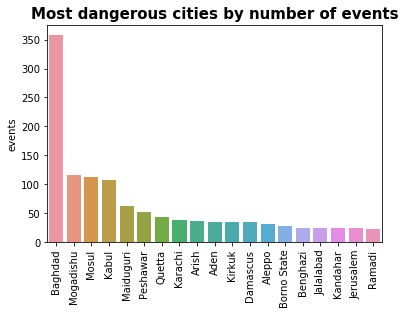

In [736]:
bar_plot(mg,'Most dangerous cities by number of events', 'events', rotation=90, sort=True, ascending=False)

**The number of events is for sure significant, but to complete our viewpoint, we will plot the same ranking by number of casualties :**

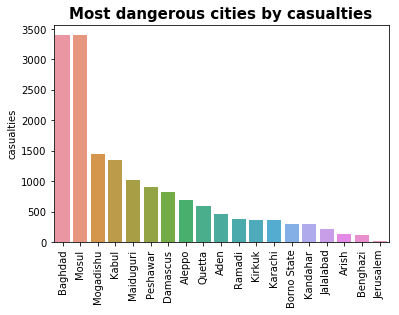

In [737]:
bar_plot(mg,'Most dangerous cities by casualties', 'casualties', rotation=90, sort=True, ascending=False)

Mosul registered 109 events, for a death toll of 3396 : an attack makes on average more than 30 victims, a sad finding of the every-day reality that happens far-away from our safe houses !

In [683]:
most_dangerous_countries = terror.groupby('country')['country'].count().sort_values(ascending=False)
most_dangerous_countries2 = terror.groupby('country').sum()['deaths'].dropna().sort_values(ascending=False)

countries = most_dangerous_countries.to_frame()
countries.columns = ['events']
countries['rank_event'] = range(1,len(countries.index)+1)
countries = countries.reset_index()
countries2 = most_dangerous_countries2.to_frame()
countries2.columns = ['casualties']
countries2['rank_casualties'] = range(1,len(countries2.index)+1)
countries2 = countries2.reset_index()
mgc = countries.merge(countries2, on='country') # We select the cities that are the most affected
mgc = mgc.set_index('country')

Iraq tops the list, and to illustrate the gap between the first few countries and the others, we will now introduce our final plot for this section, the rank by percentage of casualties :

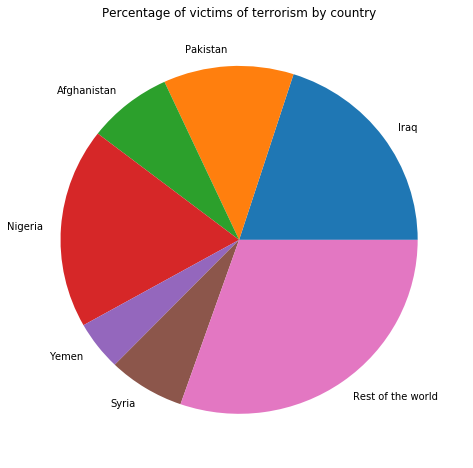

In [670]:
total_cas = mgc['casualties'].sum()
mgc['per_casualties']=mgc['casualties'].map(lambda x: 100*x/total_cas)

s = mgc.iloc[:6]['per_casualties'].sum()
others = 100-s
percentage = mgc['per_casualties'].iloc[:6].append(pd.Series({'Rest of the world':others}))
percentage.rename("").plot.pie(figsize=(8,8), title='Percentage of victims of terrorism by country')
plt.show()

In this astonishing ranking, we can highlight two important facts :

- The first **6 countries** of the list gather **more than 70%** of all deaths by terror attacks, and the other 30% are shared between all the other (around 200) countries.  
- The first European country in the list is France in 33th position. We can already imagine, before analyzing the social impact of those attacks, that this country has seen a much bigger social impact on the reactions to attacks, than most of the first 30 most hit countries.

### 3.3.3 Rise of ISIS
Avec la partie 3.2 et 3.3, on devrait avoir assez d'info a leur montrer ! 

Et si on galère niveau temps, on se replie sur displayer des trucs sur le dataset wikipedia !

## 4. Do the report